In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import mean_squared_error
import seaborn as sns

## Прогнозирование временного ряда моделью LSTM

__Функция преобразования данных для контролируемой задачи обучения__

In [2]:
# функция преобразования последовательности для контролируемой задачи обучения
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

__Функции преобразования ряда в стационарный__

In [3]:
# функция создания дифференцированного ряда (убираем тренд и сезонность)
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [4]:
# инвертировать разностное значение (возвращаем удаленную компоненту ряда)
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

__Функция масштабирования обучающих и тестовых данных к [-1,1]__

In [5]:
# функция масштабирования
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

__Функция обратного масштабирования для прогнозируемого значения__

In [25]:
# инвертирование масштабирования
def invert_scale(scaler, X, value):
    new_row = X[0].tolist() + [value]
    array = np.array(new_row).reshape(1,-1)
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

__Функция обратного масштабирования для прогноза на n шагов вперед__

In [7]:
# инвертирование масштабирования
def invert_scale_nStep(scaler, X, value):
    new_row = X[0,0].tolist() + [yhat]
    array = np.array(new_row).reshape(1,-1)
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

__Функция подгонки сети LSTM к данным обучения__

По умолчанию уровень LSTM в Keras поддерживает состояние между данными в одном пакете. Пакет данных-это фиксированное количество строк из обучающего набора данных, которое определяет, сколько шаблонов нужно обработать перед обновлением весов сети. Состояние в слое LSTM между пакетами очищается по умолчанию, поэтому мы должны сделать LSTM с сохранением состояния. Это дает нам контроль над тем, когда состояние слоя LSTM очищается, вызывая функцию reset_states ().

In [8]:
# функция обучения модели LSTM
def fit_lstm(x_train, y_train, batch_size, nb_epoch, neurons):
    # формируем модель LSTM    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # делаем сохраниение состояния LSTM между пакетами в рамках i-ой эпохи
    # затем на новой эпохе мы обновляем веса сети и очищаем состояние LSTM на новой эпохе     
    for i in range(nb_epoch):
        model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

__Функция одноэтапного прогноза__

In [9]:
# функция одноэтапного прогноза
def forecast_lstm(model, batch_size, X):
    X = X.reshape((1, 1, X.shape[1]))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

__Функция одноэтапного прогноза на n шагов вперед__

In [10]:
# функция одноэтапного прогноза на n шагов вперед
def forecast_lstm_nStep(model, batch_size, X):
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

__Оценка модели (RMSE)__

In [11]:
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

### Этапы

__1. Читаем временной ряд__

In [13]:
df = pd.read_excel("D:/Datasets/regression/all_fact16-20.xlsx", engine="openpyxl")
data = df['all'].values

# задаем индекс временного ряда
index_series = pd.date_range('2016-01-31', freq='M', periods=60)

# 1. данные для графика (преобразуем в фрейм данных с нужным индексом)
series_graph = pd.DataFrame({'All':data[:60]}, index=index_series)
# 2. данные для моделирования
series = series_graph['All'].values

series_graph.head(), series[:5], series_graph.shape, series.shape

(                    All
 2016-01-31  1239.807717
 2016-02-29  1082.035863
 2016-03-31  1104.730841
 2016-04-30   897.962429
 2016-05-31   840.153646,
 array([1239.807717, 1082.035863, 1104.730841,  897.962429,  840.153646]),
 (60, 1),
 (60,))

__2. Преобразование ряда в стационарный__

In [14]:
# ПАРАМЕТР СЕЗОННОЙ СОСТАВЛЯЮЩЕЙ (ДЛИТЕЛЬНОСТЬ СЕЗОНА)
weigth_season = 12
# ПАРАМЕТР СКОЛЬЗЯЩЕГО ОКНА (ШИРИНА БАЗОВОГО ЦИКЛА ВО ВРЕМЕННОМ РЯДУ)
window = 4

raw_values = series
diff_values = difference(raw_values, weigth_season)
diff_values.head(), diff_values.shape

(0     2.585592
 1    69.877391
 2   -16.514634
 3    76.689551
 4    31.699208
 dtype: float64,
 (48,))

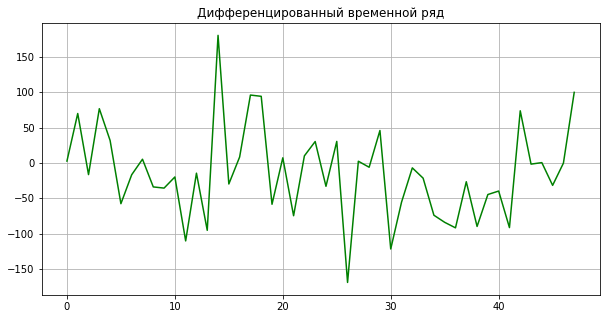

In [16]:
# график дифференцированного ряда
fig, ax = plt.subplots(figsize=(10,5))
ax.grid()
ax.set_title('Дифференцированный временной ряд')
ax.plot(diff_values, color='green')

__3. Преобразование данных для контролируемой задачи обучения__

In [17]:
supervised = timeseries_to_supervised(diff_values, window)
supervised_values = supervised.values
supervised_values[:10], supervised_values.shape

(array([[  0.        ,   0.        ,   0.        ,   0.        ,
           2.585592  ],
        [  2.585592  ,   0.        ,   0.        ,   0.        ,
          69.877391  ],
        [ 69.877391  ,   2.585592  ,   0.        ,   0.        ,
         -16.51463408],
        [-16.51463408,  69.877391  ,   2.585592  ,   0.        ,
          76.689551  ],
        [ 76.689551  , -16.51463408,  69.877391  ,   2.585592  ,
          31.699208  ],
        [ 31.699208  ,  76.689551  , -16.51463408,  69.877391  ,
         -57.662426  ],
        [-57.662426  ,  31.699208  ,  76.689551  , -16.51463408,
         -16.70597504],
        [-16.70597504, -57.662426  ,  31.699208  ,  76.689551  ,
           5.25275022],
        [  5.25275022, -16.70597504, -57.662426  ,  31.699208  ,
         -33.94016888],
        [-33.94016888,   5.25275022, -16.70597504, -57.662426  ,
         -35.60657268]]),
 (48, 5))

__4. Разделение данных на обучающие и тестовые данные__

In [18]:
train, test = supervised_values[window:-weigth_season], supervised_values[-weigth_season:]
train.shape, test.shape

((32, 5), (12, 5))

__5. Преобразование масштаба данных__

In [19]:
# в итоге получили набор train_scaled который будет разделен на (X, y) для обучения
# и test_scaled набор для тестирования
scaler, train_scaled, test_scaled = scale(train, test)
train_scaled[:5], train_scaled.shape, test_scaled[:5], test_scaled.shape

(array([[ 0.40637718, -0.12707516,  0.36738792, -0.01775538,  0.14887583],
        [ 0.14887583,  0.40637718, -0.12707516,  0.36738792, -0.36258374],
        [-0.36258374,  0.14887583,  0.40637718, -0.12707516, -0.12817029],
        [-0.12817029, -0.36258374,  0.14887583,  0.40637718, -0.00248996],
        [-0.00248996, -0.12817029, -0.36258374,  0.14887583, -0.22680986]]),
 (32, 5),
 array([[-0.5134372 , -0.45591813, -0.15582713, -0.07262916, -0.55804049],
        [-0.55804049, -0.5134372 , -0.45591813, -0.15582713, -0.18474575],
        [-0.18474575, -0.55804049, -0.5134372 , -0.45591813, -0.54677646],
        [-0.54677646, -0.18474575, -0.55804049, -0.5134372 , -0.28833121],
        [-0.28833121, -0.54677646, -0.18474575, -0.55804049, -0.26026724]]),
 (12, 5))

__6. Разделение на выборки данных для контролируемого обучения (с преобразованием в тензоры)__

In [20]:
# данные для обучения модели
x_train = train_scaled[:,0:-1]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

y_train = train_scaled[:,-1]
y_train = y_train.reshape(y_train.shape[0], 1, 1)

# данные для тестирования
x_test = test_scaled[:,0:-1]
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

y_test = test_scaled[:,-1]
y_test = y_test.reshape(y_test.shape[0], 1, 1)

x_train[:5], y_train[:5], x_train.shape, y_train.shape, x_test[:5], y_test[:5], x_test.shape, y_test.shape

(array([[[ 0.40637718, -0.12707516,  0.36738792, -0.01775538]],
 
        [[ 0.14887583,  0.40637718, -0.12707516,  0.36738792]],
 
        [[-0.36258374,  0.14887583,  0.40637718, -0.12707516]],
 
        [[-0.12817029, -0.36258374,  0.14887583,  0.40637718]],
 
        [[-0.00248996, -0.12817029, -0.36258374,  0.14887583]]]),
 array([[[ 0.14887583]],
 
        [[-0.36258374]],
 
        [[-0.12817029]],
 
        [[-0.00248996]],
 
        [[-0.22680986]]]),
 (32, 1, 4),
 (32, 1, 1),
 array([[[-0.5134372 , -0.45591813, -0.15582713, -0.07262916]],
 
        [[-0.55804049, -0.5134372 , -0.45591813, -0.15582713]],
 
        [[-0.18474575, -0.55804049, -0.5134372 , -0.45591813]],
 
        [[-0.54677646, -0.18474575, -0.55804049, -0.5134372 ]],
 
        [[-0.28833121, -0.54677646, -0.18474575, -0.55804049]]]),
 array([[[-0.55804049]],
 
        [[-0.18474575]],
 
        [[-0.54677646]],
 
        [[-0.28833121]],
 
        [[-0.26026724]]]),
 (12, 1, 4),
 (12, 1, 1))

__7.1 Обучениеи и оценка модели__

In [27]:
'''
параметры: 
x_train, y_train = X, y,
batch_size = размер батча,
epochs = количество эпох, 
lstm_cell = количество LSTM ячеек, 
raw_values = исходный временной ряд
test_scaled_length = длина строки тестовой выборки
weigth_season = длительность сезона

'''
def learn_model(x_train, y_train, batch_size, epochs, lstm_cell, raw_values, test_scaled_length, weigth_season):
    # обучение модели    
    lstm_model = fit_lstm(x_train, y_train, batch_size, epochs, lstm_cell)
    
    error_scores = list()
    predictions = list()
    for i in range(test_scaled_length):
        # сделать одноэтапный прогноз (прогноз по конкретному значению из тестовой выборки)
        X, y = x_test[i], y_test[i]
        yhat = forecast_lstm(lstm_model, 1, X)
        # инвертировать масштабирование
        yhat = invert_scale(scaler, X, yhat)
        # инвертировать дифференцирование
        yhat = inverse_difference(raw_values, yhat, test_scaled_length+1-i)
        # запись прогноза в список
        predictions.append(yhat)
    # оценка модели
    rmse = np.sqrt(mean_squared_error(raw_values[-weigth_season:], predictions))
    result_rmse = pd.Series({"Оценка модели на тестовой выборке: RMSE": rmse})
    return result_rmse, predictions

In [29]:
batch_size = 1
epochs = 1000
lstm_cell = 4
test_scaled_length = len(test_scaled)

result_rmse, predictions = learn_model(x_train, y_train, batch_size, epochs, lstm_cell, raw_values, test_scaled_length, weigth_season)
result_rmse

Оценка модели на тестовой выборке: RMSE    185.519639
dtype: float64

__График моделирования на тестовой выборке__

<AxesSubplot:title={'center':'Прогноз на тестовой выборке модели LSTM'}, xlabel='Месяцы', ylabel='Потребление'>

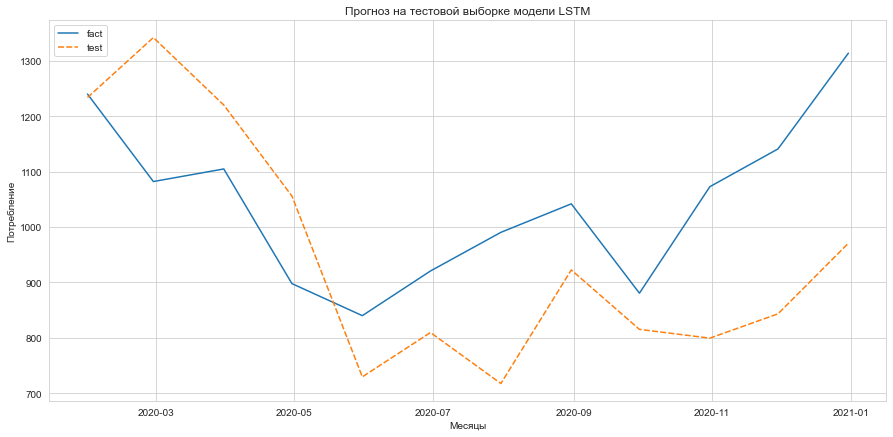

In [40]:
index_series = pd.date_range('2020-01-01', freq='M', periods=12)
df_line = pd.DataFrame({'fact': series_graph.values[:12].reshape(1,-1)[0],
                        'test': predictions}, index=index_series)

fig, ax = plt.subplots(figsize=(15,7))
sns.set_style('whitegrid', {'axes.grid': True})
plt.grid(True)
ax.set_title('Прогноз на тестовой выборке модели LSTM')
plt.xlabel('Месяцы')
plt.ylabel('Потребление')

sns.lineplot(data=df_line)

Модель рекуррентной нейронной сети LSTM в среднем ошибается на 185 млн.кВт ч. Такое отклонение от исходного временного ряда является достаточно большим.  
Преимущество модели LSTM заключается в том, что она может учиться и запоминать длинные последовательности, не полагаясь на предварительно заданное наблюдение с задержкой в окне в качестве входных данных. В рамках работы с временными рядами модели LSTM используют для прогнозирования, подгонки или переопределения обучающего набора данных, а также для обнаружения аномалий. Несмотря на это модель LSTM плохо справляется с прогнозированием одномерных временных рядов. Увеличение количества блоков памяти требует более длительного обучения модели, но не приводит к улучшению результатов. Такой результат обусловлен:  
- маленьким объемом исходных данных
- сложностью модели для применения к одномерным временным рядам